In [4]:
import pymongo
from pymongo import MongoClient

myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["mydatabase"]
mycol = mydb["customers"]

x = mycol.find_one()

print(x)

None


In [ ]:

def get_running_process(): #when someone refresh page
    try:
        COLL_NAME = "INSPECTION_"+datetime.datetime.now().strftime("%m_%y")
        mp = MongoHelper().getCollection(COLL_NAME)
        print(datetime.datetime.now())
    except Exception as e:
        message = "Cannot connect to db"
        status_code = 500
        return message,status_code
    p = [p for p in mp.find()]
    IS_COMPLEATED = True
    dummy_coll = None
    for i in p:
        print(i,'ttttttttttttttttttttttttttttttttttt')
        is_compleated =  i['is_compleated']

        if is_compleated is False:

            IS_COMPLEATED = False

            dummy_coll = i
            break

    if IS_COMPLEATED is False:
        return dummy_coll,200
    else:
        return {},200

In [ ]:
get_running_process()

In [1]:

import cv2
import threading
#from kafka import KafkaProducer
import base64
import json
import numpy as np
import datetime
from bson import ObjectId
import os
import sys
import multiprocessing
# from datetime import datetime
import pickle
import redis
import time
import requests
from common_utils import *
# import config
raw_image_path = '/home/maini/main/cameraEngine/savedimages/'

import camera_module
import dummy_cam

def config_file():
    cmd = os.system('v4l2-ctl --list-device | grep /dev/video > indexes.txt')

    config = [

    ]

    fr = open('indexes.txt','r')

    data = fr.read()
    data = data.split('\n')

    # print(data)


    camera_id = []

    counter = 0
    c = 0
    ids_list = ['cam2','cam1','cam3','cam4']#,'9cam','10cam','2cam','4cam','5cam','6cam']
    # ids_list = ['1cam','3cam','7cam','8cam','6cam','5cam','4cam','9cam','2cam']
    # ids_list = ['1cam','3cam','7cam','8cam','8cam','5cam','4cam','9cam','3cam']


    for i in data:
        if i == '':
            continue
        if counter %2 == 0:

            i = i.replace('\t','')
            # print(i)
            camera_id.append(i)
            config.append({'camera_id':i,'camera_index':ids_list[c]})
            
            c += 1

        
        counter += 1

    return config



def singleton(cls):
    instances = {}
    def getinstance():
        if cls not in instances:
            instances[cls] = cls()
        return instances[cls]
    return getinstance

@singleton
class MongoHelper:
    client = None
    def __init__(self):
        if not self.client:
            self.client = MongoClient(host='localhost', port=27017)

        self.db = self.client[settings.MONGO_DB]
        # if settings.DEBUG:
            # self.db.set_profiling_level(2)
        # placeholder for filter
    """
    def getDatabase(self):
        return self.db
    """

    def getCollection(self, cname, create=False, codec_options=None):
        _DB = "LIVIS"
        DB = self.client[_DB]
        return DB[cname]

@singleton
class CacheHelper():
    def __init__(self):
        self.redis_cache = redis.StrictRedis(host="localhost", port="6379", db=0, socket_timeout=1)
        print("REDIS CACHE UP!")

    def get_redis_pipeline(self):
        return self.redis_cache.pipeline()
    
    #should be {'key'  : 'value'} always
    def set_json(self, k, v):
        try:
            #k, v = list(dict_obj.items())[0]
            v = pickle.dumps(v)
            return self.redis_cache.set(k, v)
        except redis.ConnectionError:
            return None

    def get_json(self, key):
        try:
            temp = self.redis_cache.get(key)
            #print(temp)\
            if temp:
                temp= pickle.loads(temp)
            return temp
        except redis.ConnectionError:
            return None
        return None

    def execute_pipe_commands(self, commands):
        #TBD to increase efficiency can chain commands for getting cache in one go
        return None

def create_folder():
    main_path = raw_image_path
    date_folder = datetime.datetime.now().strftime('%y_%m_%d')
    date_path = main_path + date_folder
    part_folder = datetime.datetime.now().strftime('%H_%M_%S')
    part_path = date_path+'/'+part_folder
    print(date_path,os.path.exists(date_path))
    print(part_path,os.path.exists(part_path))
    try:
        if not(os.path.exists(date_path)):
            print('Creating Date Path')
            os.mkdir(date_path)
    except Exception as e:
        print(e)
    try:
        if not(os.path.exists(part_path)):
            print('Creating Part Path')
            os.mkdir(part_path)
        return part_path
    except Exception as e:
        print(e)

def camPreview(previewName, camID, preprocess=[]):
    print("previewName-------",previewName)
    # print(preprocess)
    frame_counter = 0

    
    # rakshith start
    # cam = cv2.VideoCapture((camID),cv2.CAP_V4L2)
    cam_data = camID.split(':')
    if cam_data[0] == 'baumer' :
        cam = camera_module.camera('baumer',cam_data[1])
    elif cam_data[0] == 'dummy2':
        cam = dummy_cam.cam2()
    elif cam_data[0] == 'dummy3':
        cam = dummy_cam.cam3()
    elif cam_data[0] == 'dummy4':
        cam = dummy_cam.cam4()

    # rakshith stop

    # cam = cv2.VideoCapture(int(camID))

    # pipeline = 'v4l2src device=/dev/video0 ! video/x-raw, framerate=30/1,width=1920,height=1080 ! videoconvert ! appsink'
    # width = 1920
    # height = 1080
    # width = 1280
    # height = 1080
    width = 1920
    height = 1080
    

    #rakshith start
    
    # if cam.isOpened():
    #     cam.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    #     cam.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    #     start_frame_number = 20
    #     cam.set(cv2.CAP_PROP_POS_FRAMES, start_frame_number)
    #     cam.set(cv2.CAP_PROP_FOURCC,cv2.VideoWriter_fourcc('M','J','P','G'))

    #     # cam.set(cv2.CAP_PROP_FPS, 9)
    #     # print(camID)
    #     # print(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))
    #     # print(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
    #     # cam.set(cv2.CAP_PROP_FOURCC,cv2.VideoWriter_fourcc('M','J','P','G'))
    #     # print(dir(cam))
    #     time.sleep(0.1)
    #     rval, frame = cam.read()
    #     print(frame.shape)
    #     # time.sleep(5)

    # else:
    #     print(previewName,'not responding')
    #     rval = False
    # print(previewName,rval)
    print(previewName)
    #rakshith stop

    

    total_count = 12
    # measured = False
    print('Programme Restarted------------------------------------------------------------------------------------------')

    while True:
        #rakshith start

        # rval, frame = cam.read()
        frame = cam.fetch_image()
        #rakshith stop
        # img = str(ObjectId()) + '.jpg'
        # b,g,r = cv2.split(frame)
        # frame = b
        
        # # frame = cv2.resize(frame,(1080,720))
        # cv2.imwrite(img, frame)
        
        # with open(img, 'rb') as f:
        #     im_b64 = base64.b64encode(f.read())
        # payload_video_frame = {"frame": str(im_b64)}
        # os.remove(img)

        # frame = cv2.resize(frame,(1920,1080))
        if previewName == 'cam3' and CacheHelper().get_json("measure_length"):
            # rval, frame = cam.read()
            CacheHelper().set_json('Stage2_Status',"started")
            part_path = create_folder()
            CacheHelper().set_json('part_path_cam_service',part_path)
            print('Part path',part_path)
            if not part_path:
                part_path = create_folder()
            # rval, frame = cam.read()
            # rval, frame = cam.read()
            cv2.imwrite('/home/maini/main/cameraEngine/savedimages/measurement.jpg', frame)
            CacheHelper().set_json('measurement', frame)
            # temp_start = datetime.datetime.now()
            # temp_count = 0
            # while 1:
                
            #     cv2.imwrite(part_path+'/measurement'+str(temp_count)+'.jpg', frame)
            #     temp_count += 1
            #     rval, frame = cam.read()
            #     if datetime.datetime.now() - temp_start >= datetime.timedelta(seconds=5):
            #         break
            cv2.imwrite(part_path+'/measurement.jpg', frame)
            cv2.imwrite('measurement.jpg', frame)
            print('\n\n\n\n\n\n\nMeasured\n\n\n\n\n\n')
            CacheHelper().set_json('measurement_complete',True)
            CacheHelper().set_json('measure_length',False)

        if CacheHelper().get_json(previewName+'_Start_Insp'):
            if frame_counter == 0:
                start = datetime.datetime.now()
                part_path = CacheHelper().get_json('part_path_cam_service')
                print('Part path',part_path)
                if not part_path:
                    part_path = create_folder()
                # if previewName=='cam3':
                #     cv2.imwrite('/home/maini/main/cameraEngine/savedimages/measurement.jpg', frame)
                #     CacheHelper().set_json('measurement', frame)
                #     cv2.imwrite(part_path+'/measurement.jpg', frame)
                #     print('\n\n\n\n\n\n\nMeasured\n\n\n\n\n\n')

            topic1=str(previewName)+"_"+str(frame_counter)
            #rakshith start

            # rval, frame = cam.read()
            frame = cam.fetch_image()
            #rakshith stop
            cv2.imwrite('/home/maini/main/cameraEngine/savedimages/raw_'+str(previewName)+'_'+str(frame_counter)+'.jpg', frame)

            cv2.imwrite(part_path+'/'+str(previewName)+'_'+str(frame_counter)+'.jpg', frame)

            CacheHelper().set_json(topic1, frame)
            print("topic1*********************",topic1)
            CacheHelper().set_json('Trigger_'+previewName,True)
            print(topic1,'Trig',frame_counter)
            frame_counter += 1
            
            if frame_counter==total_count:
                frame_counter = 0
                # measured = False
                # if previewName=='cam3':
                #     cv2.imwrite('/home/maini/main/cameraEngine/savedimages/measurement.jpg', frame)
                #     CacheHelper().set_json('measurement', frame)
                #     cv2.imwrite(part_path+'/measurement.jpg', frame)
                #     print('\n\n\n\n\n\n\nMeasured\n\n\n\n\n\n')
                print(previewName,"*****************complete****************")
                CacheHelper().set_json(previewName+'_completed',True)
                print(previewName,datetime.datetime.now() - start)
                # break
                CacheHelper().set_json(previewName+'_Start_Insp',False)
                break
            CacheHelper().set_json(previewName+'_Start_Insp',False)
        # break
    #rakshith start
    # cam.release()        
    #rakshith stop
    cv2.destroyAllWindows()

def reset():
    CacheHelper().set_json('cam1_completed',False)
    CacheHelper().set_json('cam2_completed',False)
    CacheHelper().set_json('cam3_completed',False)
    CacheHelper().set_json('cam4_completed',False)
    CacheHelper().set_json('measurement_complete',False)
    CacheHelper().set_json('measure_length',False)
    CacheHelper().set_json('cam1_Start_Insp',False)
    CacheHelper().set_json('cam2_Start_Insp',False)
    CacheHelper().set_json('cam3_Start_Insp',False)
    CacheHelper().set_json('cam4_Start_Insp',False)

def __main__():
# Create threads as follows
    print("main function")
    thread_pool = {}  
    # f = open('config.json', 'r')
    # distros_dict = json.load(f)
    distros_dict = config_file()
    print(distros_dict)
    # f.close()
    reset()
    print("after reset")
    for distro in distros_dict:  
        print("disto:::",distro)
        if 'preprocess' not in distro:
            distro['preprocess'] = [] 
        
        thread_pool[distro['camera_id']] = multiprocessing.Process(target=camPreview, args=(distro['camera_index'],distro['camera_id'], distro['preprocess']))
        # print()        
    for tt in thread_pool:
        # print('process',tt)
        thread_pool[tt].start()
        print(tt,"--------------------------------")
    for tt in thread_pool:
        thread_pool[tt].join()

    
    
if __name__ == "__main__":
    __main__() 
    cv2.destroyAllWindows()


d:\Anaconda\envs\mmnew\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Anaconda\envs\mmnew\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\Anaconda\envs\mmnew\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


ModuleNotFoundError: No module named 'common_utils'

In [4]:

from livis.settings import MONGO_DB
import pymongo
def singleton(cls):
    instances = {}
    def getinstance():
        if cls not in instances:
            instances[cls] = cls()
        return instances[cls]
    return getinstance

@singleton
class MongoHelper:
    client = None
    def __init__(self):
        if not self.client:
            self.client = pymongo.MongoClient(host='localhost', port=27017)

        self.db = self.client[MONGO_DB]
        # if settings.DEBUG:
            # self.db.set_profiling_level(2)
        # placeholder for filter
    """
    def getDatabase(self):
        return self.db
    """

    def getCollection(self, cname, create=False, codec_options=None):
        _DB = "LIVIS"
        DB = self.client[_DB]
        return DB[cname]


def list_specific_jig(jig_type):

    message = None
    status_code = None

    
   
    if jig_type is None:
        message = "jig_type not provided"
        status_code = 400
        return message,status_code

    try:
        mp = MongoHelper().getCollection('jig')
    except:
        message = "Cannot connect to db"
        status_code = 500
        return message,status_code
   
    p = [i for i in mp.find()]
   
    new_list = []
   
    for i in p:
       
        if i['jig_type'] == jig_type:
       
            new_list.append(i)
       
    return new_list,200

In [7]:
jig_type = 'AGILIS'
new_list = list_specific_jig(jig_type)
new_list

([{'_id': ObjectId('63be84976826d4edf77b1b54'),
   'jig_type': 'AGILIS',
   'oem_number': '0N-33405',
   'heatsink_match': 'HSC123',
   'palette_match': 'P-123',
   'kanban': [{'part_number': ['FGY100T65'],
     'position': 5,
     'part_type': 'IGBT'}],
   'vendor_match': ['1,15,4'],
   'is_deleted': False,
   'full_img': [{'cam_name': 'extreme_left_camera', 'regions': []},
    {'cam_name': 'left_camera', 'regions': []},
    {'cam_name': 'middle_camera', 'regions': []},
    {'cam_name': 'right_camera', 'regions': []},
    {'cam_name': 'extreme_right_camera', 'regions': []}]}],
 200)

In [7]:
def config_file1():
    config = []
    config.append({'camera_id':"baumer:192.168.1.4",'camera_index':"cam1"})
    config.append({'camera_id':"baumer:192.168.1.3",'camera_index':"cam2"})
    return config

In [2]:
user_details = {'user_id': 'b05cc995-b6b6-40ec-bd55-704c326339e0', 'username': 'anusha', 'role_name': 'admin'}
user_name = user_details['user_id']
print(type(user_name))

<class 'str'>


In [8]:
def config_file1():
    baumer_ip = []
    baumer_ip.append("192.168.1.4")
    baumer_ip.append("192.168.1.3")
    return baumer_ip

In [17]:
from common.utils import RedisKeyBuilderServer,CacheHelper,MongoHelper
import sys
import sys
sys.path.insert(0,"../livis/")
from settings import REDIS_CLIENT_HOST
from settings import REDIS_CLIENT_PORT
from settings import WORKSTATION_COLLECTION

original_frame_keyholder = 'original-frame'

mp = MongoHelper().getCollection(WORKSTATION_COLLECTION)

p = [p for p in mp.find()]

workstation_id = p[0]['_id']
print(workstation_id)

data = RedisKeyBuilderServer(workstation_id).workstation_info
cam_list = []
key_list = []
cap_list = []
for cam in data['camera_config']['cameras']:
    camera_index = cam['camera_id']
    camera_name = cam['camera_name']
    key = RedisKeyBuilderServer(workstation_id).get_key(cam['camera_id'],original_frame_keyholder) #WS-01_0_original-frame
    key_list.append(key)

5f4cce083f8fa13b3271656b


In [21]:
key_list[0]

'ws_01_1_original-frame'

In [19]:
key_list

['ws_01_1_original-frame', 'ws_01_2_original-frame']

In [34]:
from common import camera_module
baumer_ip = config_file1()
baumer_ip[0]
cam_1 = camera_module.camera('baumer',baumer_ip[0])

NotConnectedException: NotConnectedException: No device with '192.168.1.4' found.

ImproperlyConfigured: Requested setting INSTALLED_APPS, but settings are not configured. You must either define the environment variable DJANGO_SETTINGS_MODULE or call settings.configure() before accessing settings.

In [15]:
from common.utils import *
from django.utils import timezone
from bson import ObjectId
# from toyoda.utils import generate_QRcode_util
# from toyoda.utils import get_inspection_qc_list
from copy import deepcopy
import sqlite3
from xlsxwriter import Workbook
import datetime
import pymongo
from bson import ObjectId
import datetime
from datetime import date
import calendar
from csv import DictWriter

try:
    from_date = data['from_date']
except:
    from_date = None
try:
    to_date = data['to_date']
except:
    to_date = None
try:
    jig_type = data['feature_type']
except:
    jig_type = None
try:
    operator_name = data['operator_name']
except:
    operator_name = None    
try:
    status_end = data['status_type']
except:
    status_end = None  
    
try:
    on_number = data['on_number']
except:
    on_number = None  
try:
    serial_number = data['serial_number']
except:
    serial_number = None  		
        


query_1 = []
query_2 = []
resp = {}
resp_list = []
today = date.today()
month = today.strftime("%m")
year = today.strftime("20%y")
end_date = calendar.monthrange(int(year), int(month))
end_date  = str(end_date[1])
start = datetime.date(int(year), int(month), 1)
end = datetime.date(int(year), int(month), int(end_date))
# start = datetime.date(2021, 12, 23)
# print(start)
# end = datetime.date(2021, 12, 23)
# print(end)

if (from_date is not None) :
    query_1.append({'createdAt': {"$gte":from_date}})#,"$lte":to_date
elif (from_date is None ) :
    query_1.append({'createdAt': {"$gte":str(start)}})#,"$lte":to_date
if (to_date is not None) :
    query_1.append({'completedAt': {"$lte":to_date}})
elif (to_date is None) :
    query_1.append({'completedAt': {"$lte":str(end)}})
if jig_type is not None :
    query_1.append({'jig_details.jig_type': jig_type})
if on_number is not None :
    query_1.append({'jig_details.oem_number': on_number})
if operator_name is not None :
    query_1.append({'user.user_id': operator_name})
if status_end is not None:
    query_1.append({'status_end':status_end})
if serial_number is not None:
    query_1.append({'serial_no':serial_number})		
print(operator_name)
print(serial_number,'ssssssssssssssssssssssssssssssssssss')
print(query_1)



myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["LIVIS"]

all_lst = mydb.collection_names()

insp_lst = []

for a_lst in all_lst:
    if 'INSPECTION' in a_lst:
            insp_lst.append(a_lst)

for i_lst in insp_lst:

    #COLL_NAME = "INSPECTION_"+datetime.datetime.now().strftime("%m_%y")
    process_collection = MongoHelper().getCollection(i_lst)
    
    
    if bool(query_1):
        pr_ids = [i['_id'] for i in process_collection.find({"$and":query_1})]
    else:
        pr_ids = [i['_id'] for i in process_collection.find()]
        

        # for ind , pr_id in enumerate(pr_ids):
        #     res = process_collection.find({"_id":pr_id})
        #     #print(pr_id)
        #     #print(res)
        #     for r in res:
        #         if 'approved_by' in list(r.keys()):
                
        #             name = get_name_byid(r["approved_by"])
                
        #             resp_list.append({"id":ind,
        #                         "on_number": r["jig_details"]["oem_number"],
        #                         'operator_name': r['user']['name'] ,
        #                         'jig_type':r["jig_details"]["jig_type"],
        #                         "serial_number":r["serial_no"],
        #                         'scanned_at':r["createdAt"],
        #                         # "completed_at":r["completedAt"],
        #                         "status":r["status_end"],
        #                         "num_retry":r["num_retry"],
        #                         "approved_by":name})
        #         else:
        #             resp_list.append({"id":ind,
        #                 "on_number": r["jig_details"]["oem_number"],
        #                 'operator_name': r['user']['name'] ,
        #                 'jig_type':r["jig_details"]["jig_type"],
        #                 "serial_number":r["serial_no"],
        #                 'scanned_at':r["createdAt"],
        #                 # "completed_at":r["completedAt"],
        #                 "num_retry":r["num_retry"],
        #                 "status":r["status_end"],
        #                 "approved_by":None})
                   
                   
                   


None
None ssssssssssssssssssssssssssssssssssss
[{'createdAt': {'$gte': '2023-01-01'}}, {'completedAt': {'$lte': '2023-01-31'}}]


C:\Users\Rakshith\AppData\Local\Temp\ipykernel_5388\3259191371.py:92: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  all_lst = mydb.collection_names()


In [22]:
from paddleocr import PaddleOCR,draw_ocr 
import os
import matplotlib.pyplot as plt
# %matplotlib inline
import cv2
import torch
import pandas as pd
from pymongo import MongoClient
from livis import settings as s
from iteration_utilities import unique_everseen

def singleton(cls):
    instances = {}
    def getinstance():
        if cls not in instances:
            instances[cls] = cls()
        return instances[cls]
    return getinstance


@singleton
class MongoHelper:
    client = None
    def __init__(self):
        if not self.client:
            self.client = MongoClient(host=s.MONGO_SERVER_HOST, port=s.MONGO_SERVER_PORT)
        self.db = self.client[s.MONGO_DB]

    def getDatabase(self):
        return self.db

    def getCollection(self, cname, create=False, codec_options=None):
        _DB = s.MONGO_DB
        DB = self.client[_DB]
        if cname in s.MONGO_COLLECTIONS:
            if codec_options:
                return DB.get_collection(s.MONGO_COLLECTIONS[cname], codec_options=codec_options)
            return DB[s.MONGO_COLLECTIONS[cname]]
        else:
            return DB[cname]

# mp = MongoHelper().getCollection('jig')

# s = [p for p in mp.find()]

# s=s[0]
mp = MongoHelper().getCollection("jig")
for x in mp.find():
    if x['oem_number'] == 'ON-2213':
        kanban = x.get('kanban')
        if len(kanban) == 10:
            kanban = kanban[0:5]
        elif len(kanban) == 8:
            kanban = kanban[0:4]
        elif len(kanban) == 6:
            kanban = kanban[0:3]
        else:
            kanban	
        print(kanban)    				
# print(s['oem_number'])
# ON-2213
# ocr = PaddleOCR(use_angle_cls=True,use_gpu=True)
# # result = ocr.ocr(img_path)
# # print("======================")
# font = r"D:\24JAN\simfang.ttf"
# img_path = r"D:\24JAN\VCXG-201C.R\DATA\image0000035.jpg"
# model_dir = "D:/Segmentatin_yolo/LINCODE_AI_WORKER/segment/LINCODE_AI/"
# weights_path = "D:/24JAN/best.pt"

# def model_torch(img_path):
# 	img = cv2.imread(img_path)
# 	final_img = img.copy()
# 	model = torch.hub.load(model_dir,'custom',path=weights_path,source = 'local',force_reload=True,autoshape=True)
# 	model.conf = 0.25
# 	model.iou = 0.1
# 	results = model(img,size=1280)
# 	results.xyxy[0] 
# 	df = pd.DataFrame(results.pandas().xyxy[0]).sort_values('xmin')
# 	df_gen = df.loc[df.name == 'IGBT']
# 	return df_gen,final_img

# def get_kanban(oem_number):
# 	mp = MongoHelper().getCollection("jig")
# 	for x in mp.find():
# 		if x['oem_number'] == oem_number:
# 			kanban = x.get('kanban')
# 			return kanban

# def check_kanban(actual_value,predicted_value):
# 	position = {'position_present':[],'position_absent':[],'status':[]}
# 	position_actual = []
# 	position_predict = []
# 	isAccepted  = []
# 	status = []
# 	for actual,predicted in zip(actual_value,predicted_value):
# 		if actual['part_number'] == predicted['part_number']:
# 			position['position_present'].append(actual['position'])
# 			isAccepted.append('Accepted')  
# 		else:
# 			position['position_absent'].append(actual['position'])
# 			isAccepted.append('Rejected')  
# 	for value in actual_value:
# 		position_actual.append(value['position'])
# 	for value in predicted_value:
# 		position_predict.append(value['position']) 
# 	for i in position_actual:
# 		if i in position_predict:
# 			print(i)
# 		else:
# 			position['position_absent'].append(i)
# 			isAccepted.append('Rejected')  
# 	if 'Rejected' in isAccepted:
# 		position['status'].append('Rejected')
# 	else:
# 		position['status'].append('Accepted')
# 	print(isAccepted)		
# 	return  position                                 
  
# def get_ocr(img_path,oem_number):
# 	count = 1
# 	results_label = []
# 	actual = []
# 	df_gen,final_img = model_torch(img_path)
# 	for index, rows in df_gen.iterrows():
# 		ymin = int(rows["ymin"]) - 20
# 		xmax = int(rows["xmax"]) + 40
# 		ymax = int(rows["ymax"]) + 20 
# 		xmin = int(rows["xmin"]) - 40
# 		img_crp_save = final_img[ymin:ymax,xmin:xmax]
# 		results = ocr.ocr(img_crp_save)
# 		for result in results:
# 			boxes = [line[0] for line in result]
# 			labels = [line[1][0] for line in result]
# 			scores = [line[1][1] for line in result]
# 			kanban = get_kanban(oem_number)
# 			print(labels)
# 			for item in kanban:
# 				for i in item['part_number']:
# 					if i in labels:
# 						results_label.append({'part_number':[i] ,'position':count})
# 		count = count + 1
# 	return results_label 

# oem_number = '0N-456789'
# results_label= get_ocr(img_path,oem_number)
# actual_value = get_kanban(oem_number)
# predicted_value = list(unique_everseen(results_label))
# position  = check_kanban(actual_value,predicted_value)
# print(position)


# python tools/infer_det.py -c configs/det/det_mv3_db.yml -o Global.infer_img="./doc/imgs_en/image0000035.jpg" Global.pretrained_model="./output/igb_version_1/iter_epoch_100"

[{'part_number': ['30APF10'], 'position': 1, 'part_type': 'IGBT'}, {'part_number': ['K100T60'], 'position': 2, 'part_type': 'IGBT'}, {'part_number': ['40N120FL2'], 'position': 3, 'part_type': 'IGBT'}, {'part_number': ['K100T60'], 'position': 4, 'part_type': 'IGBT'}, {'part_number': ['R6076ENZ4'], 'position': 5, 'part_type': 'IGBT'}]


In [9]:
import os
print(os.getcwd())

# if (os.getcwd().split('/')[-1]) == "livis":
#     import livis.settings as s
# else:
# sys.path.insert(0,os.getcwd()+"/livis")
# import settings as s

d:\SE_PROJECT\livis-be-se-agilis_be\livis-be-se-agilis_be\AGILIS_BACKEND


In [30]:
dict2 = {"prediction": [{"part_number": ["30APF10"], "position": 6}, {"part_number": ["K100T60"], "position": 7},
{"part_number": ["40N120FL2"], "position": 8}, {"part_number": ["K100T60"], "position": 9}, {"part_number":
["R6076ENZ4"], "position": 10}]}

dict = {"prediction": [{"part_number": ["30APF10"], "position": 1}, {"part_number": ["K100T60"], "position": 2},
{"part_number": ["40N120FL2"], "position": 3}, {"part_number": ["K100T60"], "position": 4}, {"part_number":
["R6076ENZ4"], "position": 5}]}

final_dictionary = dict + dict2
print(final_dictionary)
# a[1] = a[1],b[1] 
# a[2] = a[2],b[2] 
# a[3] = a[3],b[3] 

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [33]:
from collections import defaultdict

d2 = {"prediction": [{"part_number": ["30APF10"], "position": 6}, {"part_number": ["K100T60"], "position": 7},
{"part_number": ["40N120FL2"], "position": 8}, {"part_number": ["K100T60"], "position": 9}, {"part_number":
["R6076ENZ4"], "position": 10}]}

d1 = {"prediction": [{"part_number": ["30APF10"], "position": 1}, {"part_number": ["K100T60"], "position": 2},
{"part_number": ["40N120FL2"], "position": 3}, {"part_number": ["K100T60"], "position": 4}, {"part_number":
["R6076ENZ4"], "position": 5}]}

dd = defaultdict(list)

for d in (d1, d2): # you can list as many input dicts as you want here
    for key, value in d.items():
        dd[key].append(value)
    
print(dd) 

defaultdict(<class 'list'>, {'prediction': [[{'part_number': ['30APF10'], 'position': 1}, {'part_number': ['K100T60'], 'position': 2}, {'part_number': ['40N120FL2'], 'position': 3}, {'part_number': ['K100T60'], 'position': 4}, {'part_number': ['R6076ENZ4'], 'position': 5}], [{'part_number': ['30APF10'], 'position': 6}, {'part_number': ['K100T60'], 'position': 7}, {'part_number': ['40N120FL2'], 'position': 8}, {'part_number': ['K100T60'], 'position': 9}, {'part_number': ['R6076ENZ4'], 'position': 10}]]})


d:\Anaconda\envs\mmdatanew\lib\site-packages\pkg_resources\_vendor\pyparsing.py:943: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
d:\Anaconda\envs\mmdatanew\lib\site-packages\pkg_resources\_vendor\pyparsing.py:3226: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  elif isinstance( exprs, collections.Iterable ):


[2023/01/26 13:14:22] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='C:\\Users\\Rakshith/.paddleocr/whl\\cls\\ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\Rakshith/.paddleocr/whl\\det\\ch\\ch_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_scor

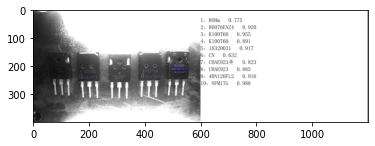

In [1]:
# pip install paddlepaddle-gpu
# pip install paddleocr


from paddleocr import PaddleOCR,draw_ocr 
import os
import matplotlib.pyplot as plt
# %matplotlib inline
import cv2
ocr = PaddleOCR(use_angle_cls=True)

# result = ocr.ocr(img_path)
# print("======================")
out_path = 'C:\\Users\\Rakshith\\Downloads\\images\\output_images'
font = r"D:\24JAN\simfang.ttf"
img_path = r"D:\24JAN\VCXG-201C.R\DATA\image0000035.jpg"
print("redddddddddddddddddddd1",img_path)
result = ocr.ocr(img_path)
for result in result:
    result = result

def save_ocr(img_path, out_path, result, font):

    save_path = os.path.join(out_path, img_path.split('/')[-1] + 'output')

    image = cv2.imread(img_path)
    print("redddddddddddddddddddd2",img_path)
    boxes = [line[0] for line in result]
    txts = [line[1][0] for line in result]
    scores = [line[1][1] for line in result]

    im_show = draw_ocr(image, boxes, txts, scores, font_path=font)
    print("redddddddddddddddddddd3",img_path)
    # cv2.imwrite(save_path, im_show)
    cv2.imwrite("drwdrw2.jpg", im_show)

    img = cv2.cvtColor(im_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

# for value,label,score in zip(boxes,labels,scores):
		# 	x1 = int(value[0][0])
		# 	y1 = int(value[0][1])
		# 	x2 = int(value[2][0])
		# 	y2 = int(value[2][1])
		# 	color  = (0,0,255)
		# 	text_color  = (255,255,255)
		# 	img_crp_save = cv2.rectangle(img_crp_save, (x1, y1), (x2, y2), color, 2)
		# 	(w, h), _ = cv2.getTextSize(
		# 			label +' '+ str(score)[:4], cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
		# 	img_crp_save = cv2.rectangle(img_crp_save, (x1, y1 - 20), (x1 + w, y1), color, -1)
		# 	img_crp_save = cv2.putText(img_crp_save, label +' '+ str(score)[:4], (x1, y1 - 5),
		# 						cv2.FONT_HERSHEY_SIMPLEX, 0.6, text_color, 2)
		# cv2.imwrite('C:/Users/Rakshith/Downloads/images/image'+str(count)+'.png', img_crp_save)
save_ocr(img_path, out_path, result, font)

In [177]:
import concurrent.futures
import urllib.request
import ast

def parallel_process():
    URLS = ['http://34.132.101.101:5000/predict',
            'http://34.132.101.101:5001/predict']
    def load_url(url, timeout):
        with urllib.request.urlopen(url, timeout=timeout) as conn:
            return conn.read()
    value  = []
    with concurrent.futures.ThreadPoolExecutor(4) as executor:
        future_to_url = {executor.submit(load_url, url, 60): url for url in URLS}
        for future in concurrent.futures.as_completed(future_to_url):
            url = future_to_url[future]
            data = future.result()
            value.append(data)
        return value       

In [ ]:
def convert(value):
    dict = {'prediction':[]}
    prediction_1 = ast.literal_eval(value[0].decode('utf-8'))
    prediction_2 =  ast.literal_eval(value[1].decode('utf-8'))
    for i in prediction_2['prediction']:
        dict['prediction'].append(i)
    for i in prediction_1['prediction']:
        dict['prediction'].append(i) 
    return dict     

In [226]:
def find_empty_value(dict):
    result_prediction = {'prediction':[]}
    for i in dict['prediction']:
        if '' in i['part_number']:
            print(True)
        else:
            result_prediction['prediction'].append({"part_number":i['part_number'],"position":i['position']})
        return result_prediction

In [25]:
from paddleocr import PaddleOCR,draw_ocr 
import os
import matplotlib.pyplot as plt
# %matplotlib inline
import cv2
import torch
import pandas as pd
from pymongo import MongoClient
from livis import settings as s
from iteration_utilities import unique_everseen
import concurrent.futures
import urllib.request
import ast
from multiprocessing.pool import ThreadPool

def singleton(cls):
    instances = {}
    def getinstance():
        if cls not in instances:
            instances[cls] = cls()
        return instances[cls]
    return getinstance

@singleton
class MongoHelper:
    client = None
    def __init__(self):
        if not self.client:
            self.client = MongoClient(host=s.MONGO_SERVER_HOST, port=s.MONGO_SERVER_PORT)
        self.db = self.client[s.MONGO_DB]

    def getDatabase(self):
        return self.db

    def getCollection(self, cname, create=False, codec_options=None):
        _DB = s.MONGO_DB
        DB = self.client[_DB]
        if cname in s.MONGO_COLLECTIONS:
            if codec_options:
                return DB.get_collection(s.MONGO_COLLECTIONS[cname], codec_options=codec_options)
            return DB[s.MONGO_COLLECTIONS[cname]]
        else:
            return DB[cname]

def parallel_process():
    URLS = ['http://35.193.71.60:5000/predict',
            'http://35.193.71.60:5001/predict']
    def load_url(url, timeout):
        with urllib.request.urlopen(url, timeout=timeout) as conn:
            return conn.read()
    value  = []
    with concurrent.futures.ThreadPoolExecutor(4) as executor:
        future_to_url = {executor.submit(load_url, url, 60): url for url in URLS}
        for future in concurrent.futures.as_completed(future_to_url):
            url = future_to_url[future]
            data = future.result()
            value.append(data)
        return future  

def convert_value(value):
    dict = {'prediction':[]}
    final_dict = {}
    prediction_1 = ast.literal_eval(value[0].decode('utf-8'))
    prediction_2 =  ast.literal_eval(value[1].decode('utf-8'))
    for i in prediction_2['prediction']:
        dict['prediction'].append(i)
    for i in prediction_1['prediction']:
        dict['prediction'].append(i) 
    list_dict = sorted(dict['prediction'], key=lambda d: d['position'])
    final_dict['prediction'] = list_dict 
    return final_dict  

def find_empty_value(dict):
    result_prediction = {'prediction':[]}
    for i in dict['prediction']:
        if '' in i['part_number']:
            pass
        else:
            result_prediction['prediction'].append({"part_number":i['part_number'],"position":i['position']})
    return result_prediction
        
def get_kanban(oem_number):
    mp = MongoHelper().getCollection("jig")
    for x in mp.find():
        if x['oem_number'] == oem_number:
            kanban = x.get('kanban')	
            return kanban

def check_kanban(actual_value,predicted_value):
    position = {'position_present':[],'position_absent':[],'status':[]}
    position_actual = []
    position_predict = []
    isAccepted  = []
    status = []
    for actual,predicted in zip(actual_value,predicted_value):
        if actual['part_number'] == predicted['part_number']:
            position['position_present'].append(actual['position'])
            isAccepted.append('Accepted')  
        else:
            position['position_absent'].append(actual['position'])
            isAccepted.append('Rejected')  
    for value in actual_value:
        position_actual.append(value['position'])
    for value in predicted_value:
        position_predict.append(value['position']) 
    for i in position_actual:
        if i in position_predict:
            pass
        else:
            position['position_absent'].append(i)
            isAccepted.append('Rejected')  
    if 'Rejected' in isAccepted:
        position['status'].append('Rejected')
    else:
        position['status'].append('Accepted')
    return  position , isAccepted 

def find_region_pass_fail(predicted_value,each_value_status,actual_value):
    for i,j,k in zip(predicted_value,each_value_status,actual_value):
        i['result_part_number'] = i['part_number']
        del i["part_number"]
        i['status']=j
        if j is 'Accepted':
            i['color']='green'
        else:
            i['color']='red'
        i['part_number'] =  k['part_number'] 
    return predicted_value   

oem_number = 'ON-2213'    
actual_value = get_kanban(oem_number)
from multiprocessing.pool import ThreadPool
pool = ThreadPool(processes=1)
async_result = pool.apply_async(parallel_process()) # tuple of args for foo
print(async_result)
# predict_ocr_value = parallel_process()
# result_dict = convert_value(predict_ocr_value)
# result_prediction = find_empty_value(result_dict)
# predicted_value = list(unique_everseen(result_prediction['prediction'])) 
# position,each_value_status  = check_kanban(actual_value,predicted_value)
# region_pass_fail = find_region_pass_fail(predicted_value,each_value_status,actual_value)
# print(region_pass_fail,position)

In [1]:
from common.utils import MongoHelper
from common.utils import RedisKeyBuilderServer,CacheHelper,MongoHelper
from bson import ObjectId
from zipfile import ZipFile
import os
import json
import uuid
import cv2
import datetime
from copy import deepcopy
import xml.etree.cElementTree as ET
import csv
from livis.constants import *
import shutil
import imutils
import random
from django.conf import settings
import os
# %matplotlib inline
import cv2
import pandas as pd
from pymongo import MongoClient
from livis import settings as s
from iteration_utilities import unique_everseen
import concurrent.futures
import urllib.request
import ast
from livis.celeryy import app
from celery import shared_task
#from livis.common_model import detection_graphm,detection_graphx,sessm,sessx,accuracy_thresholdm,accuracy_thresholdx,category_indexm,category_indexx
import datetime
import base64
import numpy as np
import requests
import cv2
import time
import requests
import cv2
import time
import gc
from billiard import Process

import subprocess

from subprocess import PIPE
from subprocess import call


 
def start_real_inspection(data1,inspection_id):

    frame = None
    crp = None

    mp = MongoHelper().getCollection(WORKSTATION_COLLECTION)

    p = [p for p in mp.find()]

    workstation_id = p[0]['_id']

    data = RedisKeyBuilderServer(workstation_id).workstation_info

    rch = CacheHelper()
    rch.set_json({"plc_insp_started":True})

    cam_list = []
    key_list = []

    for cam in data['camera_config']['cameras']:
        camera_index = cam['camera_id']
        camera_name = cam['camera_name']
        key = RedisKeyBuilderServer(workstation_id).get_key(cam['camera_id'],'original-frame') 
        cam_list.append(cam['camera_name'])
        key_list.append(key)



    ########### jig details 

    try:
        mp = MongoHelper().getCollection('WEIGHTS')
    except Exception as e:
        message = "Cannot connect to db"
        status_code = 500
        return message,status_code

    s = [p for p in mp.find()]

    s=s[0]

    try:
        mp = MongoHelper().getCollection(JIG_COLLECTION)
    except Exception as e:
        message = "Cannot connect to db"
        status_code = 500
        return message,status_code

    jig_id =  data1['jig_id']
    if jig_id is None:
        message = "jig id not provided"
        status_code = 400
        return message,status_code

    try:
        dataset = mp.find_one({'_id' : ObjectId(jig_id)})
        if dataset is None:
            message = "Jig not found in Jig collection"
            status_code = 404
            return message,status_code

    except Exception as e:
        message = "Invalid jigID"
        status_code = 400
        return message,status_code
    

    oem_number = data1['oem_number']
    jig_type = dataset['jig_type']
    vendor_match = dataset['vendor_match']
    copy_of_vendor_match = vendor_match
    def do_del(cl_obj):
        try:
            del cl_obj
        except Exception as e:
            pass
            #print("del ops")
            #print(e)
    retry_list = []
    while(True):
        if retry_list != []:

            var = str(ObjectId(dataset['_id'])) + "_paused"
            is_paused = rch.get_json(var)
            #rch.set_json({var:p1_lst})

            if is_paused:
                continue       
        try:
            COLL_NAME = "INSPECTION_"+datetime.datetime.now().strftime("%m_%y")
            mp = MongoHelper().getCollection(COLL_NAME)
        except Exception as e:
            message = "Cannot connect to db"
            status_code = 500
            return message,status_code


        try:
            dataset = mp.find_one({'_id' : ObjectId(inspection_id)})
            if dataset is None:
                message = "Inspection not found in inspection collection"
                status_code = 404
                return message,status_code

        except Exception as e:
            message = "Invalid inspection ID"
            status_code = 400
            return message,status_code


        is_manual_pass = dataset['is_manual_pass']
        is_reject = dataset['is_reject']

        if is_manual_pass is True:
            print("manual pass is true")
            break
        if is_reject is True:
            print("part rejection is true")
            break
        
        def parallel_process():
            URLS = ['http://35.193.71.60:5000/predict',
                'http://35.193.71.60:5001/predict']
            def load_url(url, timeout):
                with urllib.request.urlopen(url, timeout=timeout) as conn:
                    return conn.read()
            value  = []
            with concurrent.futures.ThreadPoolExecutor(4) as executor:
                future_to_url = {executor.submit(load_url, url, 60): url for url in URLS}
                for future in concurrent.futures.as_completed(future_to_url):
                    url = future_to_url[future]
                    data = future.result()
                    value.append(data)
                return value  

        def convert_value(value):
            dict = {'prediction':[]}
            final_dict = {}
            prediction_1 = ast.literal_eval(value[0].decode('utf-8'))
            prediction_2 =  ast.literal_eval(value[1].decode('utf-8'))
            for i in prediction_2['prediction']:
                dict['prediction'].append(i)
            for i in prediction_1['prediction']:
                dict['prediction'].append(i) 
            list_dict = sorted(dict['prediction'], key=lambda d: d['position'])
            final_dict['prediction'] = list_dict 
            return final_dict  

        def find_empty_value(dict):
            result_prediction = {'prediction':[]}
            for i in dict['prediction']:
                if '' in i['part_number']:
                    pass
                else:
                    result_prediction['prediction'].append({"part_number":i['part_number'],"position":i['position']})
            return result_prediction
                
        def get_kanban(oem_number):
            mp = MongoHelper().getCollection("jig")
            for x in mp.find():
                if x['oem_number'] == oem_number:
                    kanban = x.get('kanban')	
                    return kanban

        def check_kanban(actual_value,predicted_value):
            position = {'position_present':[],'position_absent':[],'status':[]}
            position_actual = []
            position_predict = []
            isAccepted  = []
            status = []
            for actual,predicted in zip(actual_value,predicted_value):
                if actual['part_number'] == predicted['part_number']:
                    position['position_present'].append(actual['position'])
                    isAccepted.append('Accepted')  
                else:
                    position['position_absent'].append(actual['position'])
                    isAccepted.append('Rejected')  
            for value in actual_value:
                position_actual.append(value['position'])
            for value in predicted_value:
                position_predict.append(value['position']) 
            for i in position_actual:
                if i in position_predict:
                    pass
                else:
                    position['position_absent'].append(i)
                    isAccepted.append('Rejected')  
            if 'Rejected' in isAccepted:
                position['status'].append(False)
            else:
                position['status'].append(True)
            return  position , isAccepted 

        def find_region_pass_fail(predicted_value,each_value_status,actual_value):
            for i,j,k in zip(predicted_value,each_value_status,actual_value):
                i['result_part_number'] = i['part_number']
                del i["part_number"]
                i['status']=j
                if j == 'Accepted':
                    i['color']='green'
                else:
                    i['color']='red'
                i['part_number'] =  k['part_number'] 
            return predicted_value 

        
        final_dct = {}
        print(oem_number,'hjoemmmmmmmmmmmmmmmmmmmmmmmmm')
        actual_value = get_kanban(str(oem_number))
        print(actual_value,'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkk')
        predict_ocr_value = parallel_process()
        result_dict = convert_value(predict_ocr_value)
        result_prediction = find_empty_value(result_dict)
        predicted_value = list(unique_everseen(result_prediction['prediction'])) 
        position,each_value_status  = check_kanban(actual_value,predicted_value)
        region_pass_fail = find_region_pass_fail(predicted_value,each_value_status,actual_value)
        print(region_pass_fail,'jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj')
        print(position)
       
        #write to redis : key is inspection_id and value is region_pass_fail
        rch.set_json({inspection_id:region_pass_fail})
        var = str(inspection_id) + "_result"
        rch.set_json({var:"fail"})

        IS_PROCESS_END = True
        if position['status'] is True:
                pass
        else:
            IS_PROCESS_END = False

        if IS_PROCESS_END:
            break

        retry_list.append(region_pass_fail)
        print("LENGTH!!")
        print(len(retry_list))
        var = str(inspection_id) + "_retry_array"
        rch.set_json({var:retry_list})

        if len(retry_list) == 0:
            pass
        elif len(retry_list) >= 1:

            try:
                rch = CacheHelper()
                var = str(ObjectId(dataset['_id'])) + "_paused"
                #is_paused = rch.get_json(var)
                rch.set_json({var:True})
            except:
                return "error setting redis",400
        
        var = str(inspection_id) + "_result"
        rch.set_json({var:"pass"})

        try:
            COL_NAME = "INSPECTION_"+datetime.datetime.now().strftime("%m_%y")
            mp = MongoHelper().getCollection(COL_NAME)
        except Exception as e:
            message = "Cannot connect to db"
            status_code = 500
            return message,status_code


        try:
            dataset = mp.find_one({'_id' : ObjectId(inspection_id)})
            if dataset is None:
                message = "Inspection not found in inspection collection"
                status_code = 404
                return message,status_code

        except Exception as e:
            message = "Invalid inspection ID"
            status_code = 400
            return message,status_code

        dataset['completedAt'] = datetime.datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
        completedAt = datetime.datetime.strptime(dataset['completedAt'], '%Y-%m-%d %H:%M:%S')
        createdAt = datetime.datetime.strptime(dataset['createdAt'], '%Y-%m-%d %H:%M:%S')
        duration = completedAt - createdAt
        dataset['duration'] = str(duration)
        dataset['status'] = 'completed'
        dataset['is_compleated'] = True
        
        mp.update_one({'_id' : ObjectId(dataset['_id'])}, {'$set' :  dataset})
        gc.collect()



d:\Anaconda\envs\mmtest\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Anaconda\envs\mmtest\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\Anaconda\envs\mmtest\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


D:\SE_PROJECT\livis-be-se-agilis_be\livis-be-se-agilis_be\AGILIS_BACKEND
AREEEEE: : : : :    D:\SE_PROJECT\livis-be-se-agilis_be\livis-be-se-agilis_be\AGILIS_BACKEND/training/image_data/
d:\SE_PROJECT\livis-be-se-agilis_be\livis-be-se-agilis_be\AGILIS_BACKEND
AREEEEE: : : : :    d:\SE_PROJECT\livis-be-se-agilis_be\livis-be-se-agilis_be\AGILIS_BACKEND/training/image_data/


In [95]:
from common.utils import MongoHelper
from common.utils import RedisKeyBuilderServer,CacheHelper,MongoHelper
from bson import ObjectId
from zipfile import ZipFile
import os
import json
import uuid
import cv2
import datetime
from copy import deepcopy
import xml.etree.cElementTree as ET
import csv
from livis.constants import *
import shutil
import imutils
import random
from django.conf import settings
import os
# %matplotlib inline
import cv2
import pandas as pd
from pymongo import MongoClient
from livis import settings as s
from iteration_utilities import unique_everseen
import concurrent.futures
import urllib.request
import ast
from livis.celeryy import app
from celery import shared_task
#from livis.common_model import detection_graphm,detection_graphx,sessm,sessx,accuracy_thresholdm,accuracy_thresholdx,category_indexm,category_indexx
import datetime
import base64
import numpy as np
import requests
import cv2
import time
import requests
import cv2
import time
import gc
from billiard import Process

import subprocess

from subprocess import PIPE
from subprocess import call

def start_real_inspection(data1,inspection_id):

    frame = None
    crp = None

    mp = MongoHelper().getCollection(WORKSTATION_COLLECTION)

    p = [p for p in mp.find()]

    workstation_id = p[0]['_id']

    data = RedisKeyBuilderServer(workstation_id).workstation_info

    rch = CacheHelper()
    rch.set_json({"plc_insp_started":True})

    cam_list = []
    key_list = []

    for cam in data['camera_config']['cameras']:
        key = RedisKeyBuilderServer(workstation_id).get_key(cam['camera_id'],'original-frame') 
        cam_list.append(cam['camera_name'])
        key_list.append(key)

    ########### jig details 
    try:
        mp = MongoHelper().getCollection(JIG_COLLECTION)
    except Exception as e:
        message = "Cannot connect to db"
        status_code = 500
        return message,status_code

    jig_id =  data1['jig_id']
    if jig_id is None:
        message = "jig id not provided"
        status_code = 400
        return message,status_code

    try:
        dataset = mp.find_one({'_id' : ObjectId(jig_id)})
        if dataset is None:
            message = "Jig not found in Jig collection"
            status_code = 404
            return message,status_code

    except Exception as e:
        message = "Invalid jigID"
        status_code = 400
        return message,status_code
    
    oem_number = dataset['oem_number']
    jig_type = dataset['jig_type']
    vendor_match = dataset['vendor_match']

    try:
        kanban = dataset['kanban']
        #print("KANBAN" , kanban )
    except:
        message = "error in kanban/not set"
        status_code = 400
        return message,status_code

    if kanban is None:
        message = "error in kanban/not set"
        status_code = 400
        return message,status_code


    #write a while true loop : if final dict match with kanban  or manual pass by admin using inspection_id
    t_start_inspection = time.time()

    loop_idx_for_del = 0

    def do_del(cl_obj):
        try:
            del cl_obj
        except Exception as e:
            print("del ops")
            print(e)

    retry_list = []

    while(True):
        if retry_list != []:

            var = str(ObjectId(dataset['_id'])) + "_paused"
            is_paused = rch.get_json(var)
            #rch.set_json({var:p1_lst})

            if is_paused:
                #print("i am paused")
                continue
                
        print("Testing here")
        try:
            COL_NAME = "INSPECTION_"+datetime.datetime.now().strftime("%m_%y")
            mp = MongoHelper().getCollection(COL_NAME)
        except Exception as e:
            message = "Cannot connect to db"
            status_code = 500
            return message,status_code


        try:
            dataset = mp.find_one({'_id' : ObjectId(inspection_id)})
            if dataset is None:
                message = "Inspection not found in inspection collection"
                status_code = 404
                return message,status_code

        except Exception as e:
            message = "Invalid inspection ID"
            status_code = 400
            return message,status_code


        is_manual_pass = dataset['is_manual_pass']
        is_reject = dataset['is_reject']

        if is_manual_pass is True:
            print("manual pass is true")
            break
        if is_reject is True:
            print("part rejection is true")
            break
        
        final_dct = {}
        
        def parallel_process():
            URLS = ['http://35.193.71.60:5000/predict',
                    'http://35.193.71.60:5001/predict']
            def load_url(url, timeout):
                with urllib.request.urlopen(url, timeout=timeout) as conn:
                    return conn.read()
            value  = []
            with concurrent.futures.ThreadPoolExecutor(4) as executor:
                future_to_url = {executor.submit(load_url, url, 60): url for url in URLS}
                for future in concurrent.futures.as_completed(future_to_url):
                    url = future_to_url[future]
                    data = future.result()
                    value.append(data)
                return value  

        def convert_value(value):
            dict = {'prediction':[]}
            final_dict = {}
            prediction_1 = ast.literal_eval(value[0].decode('utf-8'))
            prediction_2 =  ast.literal_eval(value[1].decode('utf-8'))
            for i in prediction_2['prediction']:
                dict['prediction'].append(i)
            for i in prediction_1['prediction']:
                dict['prediction'].append(i) 
            list_dict = sorted(dict['prediction'], key=lambda d: d['position'])
            final_dict['prediction'] = list_dict 
            return final_dict  

        def find_empty_value(dict):
            result_prediction = {'prediction':[]}
            for i in dict['prediction']:
                if '' in i['part_number']:
                    pass
                else:
                    result_prediction['prediction'].append({"part_number":i['part_number'],"position":i['position']})
            return result_prediction
                
        def get_kanban(oem_number):
            mp = MongoHelper().getCollection("jig")
            for x in mp.find():
                if x['oem_number'] == oem_number:
                    kanban = x.get('kanban')	
                    return kanban

        def check_kanban(actual_value,predicted_value):
            position = {'position_present':[],'position_absent':[]}
            position_actual = []
            position_predict = []
            isAccepted  = []
            status = []
            for actual,predicted in zip(actual_value,predicted_value):
                if actual['part_number'] == predicted['part_number']:
                    position['position_present'].append(actual['position'])
                    isAccepted.append(True)  
                else:
                    position['position_absent'].append(actual['position'])
                    isAccepted.append(False)  
            for value in actual_value:
                position_actual.append(value['position'])
            for value in predicted_value:
                position_predict.append(value['position']) 
            for i in position_actual:
                if i in position_predict:
                    pass
                else:
                    position['position_absent'].append(i)
                    isAccepted.append(False)  
            if False in isAccepted:
                position['status'] = False
            else:
                position['status'] = True
            return  position , isAccepted 

        def find_region_pass_fail(predicted_value,each_value_status,actual_value):
            for i,j,k in zip(predicted_value,each_value_status,actual_value):
                i['result_part_number'] = i['part_number']
                del i["part_number"]
                i['status']=j
                if j == 'Accepted':
                    i['color']='green'
                else:
                    i['color']='red'
                i['part_number'] =  k['part_number'] 
            return predicted_value 

        
        final_dct = {}
        print(oem_number,'hjoemmmmmmmmmmmmmmmmmmmmmmmmm')
        actual_value = get_kanban(str(oem_number))
        print(actual_value,'kkkkkkkkkkkkkkkkkkkkkkkkkkkkkk')
        predict_ocr_value = parallel_process()
        result_dict = convert_value(predict_ocr_value)
        result_prediction = find_empty_value(result_dict)
        predicted_value = list(unique_everseen(result_prediction['prediction'])) 
        position,each_value_status  = check_kanban(actual_value,predicted_value)
        region_pass_fail = find_region_pass_fail(predicted_value,each_value_status,actual_value)
        print(region_pass_fail,'jjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj')
        print(position)

        var = str(inspection_id) + "_position_value"
        rch.set_json({var:position})

        #write to redis : key is inspection_id and value is region_pass_fail
        rch.set_json({inspection_id:region_pass_fail})
        var = str(inspection_id) + "_result"
        rch.set_json({var:"fail"})

        cycle_time_key = str(inspection_id) + "_cycletime"
        rch.set_json({cycle_time_key: time.time() - t_start_inspection })

        IS_PROCESS_END = True
        for final_check in region_pass_fail:
            if final_check['status'] is True:
                pass
            else:
                IS_PROCESS_END = False

        print(IS_PROCESS_END)
        if IS_PROCESS_END:
            break

        retry_list.append(region_pass_fail)
        print("LENGTH!!")
        print(len(retry_list))
        var = str(inspection_id) + "_retry_array"
        rch.set_json({var:retry_list})

        if len(retry_list) == 0:
            pass
        elif len(retry_list) >= 1:
            try:
                rch = CacheHelper()
                var = str(ObjectId(dataset['_id'])) + "_paused"
                #is_paused = rch.get_json(var)
                rch.set_json({var:True})
            except:
                return "error setting redis",400

            
        try: do_del(mp)
        except: pass
        try: do_del(message)
        except: pass
        try: do_del(status_code)
        except: pass
        try: do_del(dataset)
        except: pass
        try: do_del(is_manual_pass)
        except: pass
        try: do_del(cam_list)
        except: pass
        try: do_del(key_list)
        except: pass
        try: do_del(region_pass_fail)
        except: pass
        try: do_del(e)
        except: pass
        try: do_del(final_dct)
        except: pass  
        try: do_del(var)
        except: pass
        try: do_del(key)
        except: pass
        try: do_del(vendor_match)
        except: pass

        try: gc.collect()
        except: pass        
        
        var = str(inspection_id) + "_result"
        rch.set_json({var:"pass"})

        try:
            COL_NAME = "INSPECTION_"+datetime.datetime.now().strftime("%m_%y")
            mp = MongoHelper().getCollection(COL_NAME)
        except Exception as e:
            message = "Cannot connect to db"
            status_code = 500
            return message,status_code


        try:
            dataset = mp.find_one({'_id' : ObjectId(inspection_id)})
            if dataset is None:
                message = "Inspection not found in inspection collection"
                status_code = 404
                return message,status_code

        except Exception as e:
            message = "Invalid inspection ID"
            status_code = 400
            return message,status_code

        dataset['completedAt'] = datetime.datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
        completedAt = datetime.datetime.strptime(dataset['completedAt'], '%Y-%m-%d %H:%M:%S')
        createdAt = datetime.datetime.strptime(dataset['createdAt'], '%Y-%m-%d %H:%M:%S')
        duration = completedAt - createdAt
        dataset['duration'] = str(duration)
        dataset['status'] = 'completed'
        dataset['is_compleated'] = True

        manual_pss = dataset['is_manual_pass']
        manual_rej = dataset['is_reject']
        
        if manual_pss:
            dataset['status_end'] = "Manually Pass"
        elif manual_rej:
            dataset['status_end'] = "Manually Rejected"
        else:
            dataset['status_end'] = "Auto Pass"
        
        var = str(inspection_id) + "_retry_array"

        retry_array = rch.get_json(var)
        print(retry_array,'cccccccccccccccccccccccccccccccccccc')

        if retry_array is None:
            dataset['num_retry'] = 0
        else:
            dataset['num_retry'] = int(len(retry_array)) - 1 
        
        mp.update_one({'_id' : ObjectId(dataset['_id'])}, {'$set' :  dataset})
    #do gc collect here
        gc.collect()

        return 200
    

In [6]:

def get_running_process(): #when someone refresh page
    try:
        COLL_NAME = "INSPECTION_"+datetime.datetime.now().strftime("%m_%y")
        mp = MongoHelper().getCollection(COLL_NAME)
        print(datetime.datetime.now())
    except Exception as e:
        message = "Cannot connect to db"
        status_code = 500
        return message,status_code
    p = [p for p in mp.find()]
    IS_COMPLEATED = True
    dummy_coll = None
    for i in p:
        print(i,'ttttttttttttttttttttttttttttttttttt')
        is_compleated =  i['is_compleated']

        if is_compleated is False:

            IS_COMPLEATED = False

            dummy_coll = i
            break

    if IS_COMPLEATED is False:
        return dummy_coll,200
    else:
        return {},200

        

In [7]:
val = get_running_process()
print(val)

2023-02-06 12:24:44.775442
{'_id': ObjectId('63da1541fb1fe50c99ab34ad'), 'jig_details': {'_id': ObjectId('63d6165e6867c5f9533b7b2a'), 'jig_type': 'AGILIS', 'oem_number': 'ON-2213', 'heatsink_match': 'ON-2213', 'palette_match': 'POLY199', 'kanban': [{'part_number': ['30APF10'], 'part_type': 'IGBT', 'position': 1}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 2}, {'part_number': ['40N120FL2'], 'part_type': 'IGBT', 'position': 3}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 4}, {'part_number': ['R6076ENZ4'], 'part_type': 'IGBT', 'position': 5}, {'part_number': ['30APF11'], 'part_type': 'IGBT', 'position': 6}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 7}, {'part_number': ['40N120FL2'], 'part_type': 'IGBT', 'position': 8}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 9}, {'part_number': ['R6076ENZ4'], 'part_type': 'IGBT', 'position': 10}], 'vendor_match': ['1,15,4'], 'is_deleted': False, 'full_img': [{'cam_name': 'extre

In [9]:
var = str('63dfce54d4a606636992653e') + "_retry_array"
rch = CacheHelper()
retry_array = rch.get_json(var)
print(len(retry_array))
# if retry_array is None:
#     print(0)
#     print('yes')
# else:
#     print(int(len(retry_array)) - 1)
#     print('no')

1


In [7]:
var = str('63de8627b15a224ce8f08edd') + "_result"
print(rch.get_json(var))

fail


In [70]:
IS_PROCESS_END = True
data = [{'position': 1, 'result_part_number': ['30APF10'], 'status': False, 'color': 'red', 'part_number': ['30APF10']}, {'position': 2, 'result_part_number': ['K100T60'], 'status': True, 'color': 'red', 'part_number': ['K100T60']}, {'position': 3, 'result_part_number': ['40N120FL2'], 'status': True, 'color': 'red', 'part_number': ['40N120FL2']}, {'position': 4, 'result_part_number': ['K100T60'], 'status': True, 'color': 'red', 'part_number': ['K100T60']}, {'position': 5, 'result_part_number': ['R6076ENZ4'], 'status': True, 'color': 'red', 'part_number': ['R6076ENZ4']}, {'position': 6, 'result_part_number': ['30APF10'], 'status': True, 'color': 'red', 'part_number': ['30APF11']}, {'position': 7, 'result_part_number': ['K100T60'], 'status': True, 'color': 'red', 'part_number': ['K100T60']}, {'position': 8, 'result_part_number': ['40N120FL2'], 'status': True, 'color': 'red', 'part_number': ['40N120FL2']}, {'position': 9, 'result_part_number': ['K100T60'], 'status': True, 'color': 'red', 'part_number': ['K100T60']}, {'position': 10, 'result_part_number': ['R6076ENZ4'], 'status': True, 'color': 'red', 'part_number': ['R6076ENZ4']}]
for final_check in data:
    if bool(final_check['status']):
        pass
    else:
        IS_PROCESS_END = False
print(IS_PROCESS_END)
data2 = ['2','2','2']
if IS_PROCESS_END is True or len(data2)==4:
    print('break')

False


In [9]:
auto_reject = True
if auto_reject == True:
    print('Auto Reject')

Auto Reject


In [96]:
inspection_id =  '63dfce54d4a606636992653e'
data1 = {'jig_id': '63d6165e6867c5f9533b7b2a', 'jig_type': 'AGILIS', 'barcode': '', 'oem_number': 'ON-2213', 'user_id': 'cf2afc97-6105-4a87-a160-c7c35885c39d', 'workstation_id': '5f4cce083f8fa13b3271656b'}
start_real_inspection(data1,inspection_id)

Testing here
ON-2213 hjoemmmmmmmmmmmmmmmmmmmmmmmmm
[{'part_number': ['30APF10'], 'part_type': 'IGBT', 'position': 1}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 2}, {'part_number': ['40N120FL2'], 'part_type': 'IGBT', 'position': 3}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 4}, {'part_number': ['R6076ENZ4'], 'part_type': 'IGBT', 'position': 5}, {'part_number': ['30APF11'], 'part_type': 'IGBT', 'position': 6}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 7}, {'part_number': ['40N120FL2'], 'part_type': 'IGBT', 'position': 8}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 9}, {'part_number': ['R6076ENZ4'], 'part_type': 'IGBT', 'position': 10}] kkkkkkkkkkkkkkkkkkkkkkkkkkkkkk
[{'position': 1, 'result_part_number': ['30APF10'], 'status': True, 'color': 'red', 'part_number': ['30APF10']}, {'position': 2, 'result_part_number': ['K100T60'], 'status': True, 'color': 'red', 'part_number': ['K100T60']}, {'position': 3, 'result

200

In [10]:
def get_current_inspection_details_utils(inspection_id):
    #{eval_data}

    #inspection_id =  data['inspection_id']
    if inspection_id is None:
        message = "inspection_id not provided"
        status_code = 400
        return message,status_code

    try:
        COLL_NAME = "INSPECTION_"+datetime.datetime.now().strftime("%m_%y")
        mp = MongoHelper().getCollection(COLL_NAME)
    except Exception as e:
        message = "Cannot connect to db"
        status_code = 500
        return message,status_code

    try:
        dataset = mp.find_one({'_id' : ObjectId(inspection_id)})
        if dataset is None:
            message = "Inspection not found in inspection collection"
            status_code = 404
            return message,status_code

    except Exception as e:
        message = "Invalid inspection ID"
        status_code = 400
        return message,status_code

    jig_type = dataset['jig_details']['jig_type']
    curr_ser_numb = dataset['serial_no']

    samp = {}
    if True:
        #samp = {}
        rch = CacheHelper()
        details = rch.get_json(str(inspection_id))
        var = str(inspection_id) + "_result"
        result = rch.get_json(var)
        
        if details is not None:
            print("details is not None")
            print(details)
     
        samp['status'] = result 
        """
        if len(blank) == 0:
            samp['evaluation_data'] = details
        else:
            samp['evaluation_data'] = blank
        """
        if details is None:
            samp['evaluation_data'] = details
        else:
            a_z = details.copy()
            for i_z in a_z:
                new_part_number = []
                part_number = i_z['part_number']
                for j_z in part_number:
                    if '_' in str(j_z): 
                        s_z = j_z.split('_')[0]
                        new_part_number.append(s_z)
                    else:
                        new_part_number.append(j_z)
                i_z['part_number'] = new_part_number
                new_res_pn = i_z['result_part_number']
                if new_res_pn is not None:
                    if '_' in i_z['result_part_number']:
                        i_z['result_part_number'] = str(new_res_pn).split('_')[0]
                
            samp['evaluation_data'] = a_z
        var = str(inspection_id) + "_retry_array"
        retry_array = rch.get_json(var)
        print(retry_array,'gggggggggggggggggggggggg')
        if retry_array is None:
            print("length of retry array is :0")
        else:
            print("length of retry array is :"+ str(len(retry_array)))
        if retry_array is None:
            samp['retry_array'] = []
        else:
            samp['retry_array'] = retry_array
        

        report = {}
        ## cycle time 
        cycle_time_key = str(inspection_id) + "_cycletime"
        curr_cycle_time = rch.get_json(cycle_time_key)
        report['process_time'] = str(curr_cycle_time)
        var = str(inspection_id) + "_prediction_time"
        prediction_time = rch.get_json(var)
        report['previous_cycle_time'] = str(prediction_time) + " sec"
        #qty_built : total amt of gvm and gvx built for today 
        Qty_built = 0


        p = [p for p in mp.find().sort( "$natural", -1 )]
        pq = [p for p in mp.find().sort( "$natural", -1 )]
        #pq = [p for p in mp.find()]
        
        total_inspections = 0 
        total_manual_pass = 0
        total_multi_try = 0
        total_one_time_pass = 0
        for i in p:

            # check for the day wise report 

            start_time = str(i['createdAt'].split(" ")[0])
            current_date = str(datetime.datetime.now().strftime("%Y-%m-%d"))

            if start_time == current_date:

                #break when manual_reset is hit (is_admin_report_reset)

                is_compleated =  i['is_compleated']
                if is_compleated is True:
                    Qty_built = Qty_built + 1

                total_inspections = total_inspections + 1

                if i['is_manual_pass'] is True:
                    total_manual_pass = total_manual_pass + 1
                    
                num_retry =  i['num_retry']
                if num_retry is not None:
                    if num_retry > 0:
                        total_multi_try = total_multi_try + 1

                if i['is_admin_report_reset'] is True:
                    break
                
        
        report['total_parts_scanned'] = str(Qty_built)      
        report['previous_barcode_number'] = "AGFS123465"
        # Previous barcode scanned 
        if len(pq) >= 2:
            #report['previous_barcode_number'] = pq[1]['serial_no']
            report['previous_barcode_number'] = str(curr_ser_numb)
        ## total inspection per day until reset
        #total_inspections = len(p) - 1
        #pr = [i for i in mp.find({"is_manual_pass" : True})]
        print("total inspections",total_inspections)
        print("total_multi_try",total_multi_try)
        total_auto_pass = str(total_inspections - total_manual_pass)
        total_one_time_pass = str(total_inspections - total_multi_try)

        fpy = 0.0
        if int(total_inspections) > 0:
            fpy = float(total_one_time_pass)  / float(total_inspections)
            fpy = (fpy*100)
            fpy = round(fpy,2)
            fpy = str(fpy) + " %"
        report['auto_pass'] = total_auto_pass
        report['manual_pass'] = str(total_manual_pass)
        report['fpy'] = fpy
        samp['reports'] = report
        
        try: del dataset,mp,message,details,var,result,report,p,pr
        except : pass
        
        gc.collect()
        #print(samp)
        return samp, 200

In [11]:
inspection_id =  '63dfce54d4a606636992653e'
samp = get_current_inspection_details_utils(inspection_id)
print(samp)

details is not None
[{'position': 1, 'result_part_number': ['30APF10'], 'status': 'Accepted', 'color': 'green', 'part_number': ['30APF10']}, {'position': 2, 'result_part_number': ['K100T60'], 'status': 'Accepted', 'color': 'green', 'part_number': ['K100T60']}, {'position': 3, 'result_part_number': ['40N120FL2'], 'status': 'Accepted', 'color': 'green', 'part_number': ['40N120FL2']}, {'position': 4, 'result_part_number': ['K100T60'], 'status': 'Accepted', 'color': 'green', 'part_number': ['K100T60']}, {'position': 5, 'result_part_number': ['R6076ENZ4'], 'status': 'Accepted', 'color': 'green', 'part_number': ['R6076ENZ4']}, {'position': 6, 'result_part_number': ['30APF10'], 'status': 'Rejected', 'color': 'red', 'part_number': ['30APF11']}, {'position': 7, 'result_part_number': ['K100T60'], 'status': 'Accepted', 'color': 'green', 'part_number': ['K100T60']}, {'position': 8, 'result_part_number': ['40N120FL2'], 'status': 'Accepted', 'color': 'green', 'part_number': ['40N120FL2']}, {'positio

In [ ]:
data = [{'position': 1, 'result_part_number': ['30APF10'], 'status': 'Accepted', 'color': 'green', 'part_number': ['30APF10']}, {'position': 2, 'result_part_number': ['K100T60'], 'status': 'Accepted', 'color': 'green', 'part_number': ['K100T60']}, {'position': 3, 'result_part_number': ['40N120FL2'], 'status': 'Accepted', 'color': 'green', 'part_number': ['40N120FL2']}, {'position': 4, 'result_part_number': ['K100T60'], 'status': 'Accepted', 'color': 'green', 'part_number': ['K100T60']}, {'position': 5, 'result_part_number': ['R6076ENZ4'], 'status': 'Accepted', 'color': 'green', 'part_number': ['R6076ENZ4']}, {'position': 6, 'result_part_number': ['30APF10'], 'status': 'Accepted', 'color': 'green', 'part_number': ['30APF10']}, {'position': 7, 'result_part_number': ['K100T60'], 'status': 'Accepted', 'color': 'green', 'part_number': ['K100T60']}, {'position': 8, 'result_part_number': ['40N120FL2'], 'status': 'Accepted', 'color': 'green', 'part_number': ['40N120FL2']}, {'position': 9, 'result_part_number': ['K100T60'], 'status': 'Accepted', 'color': 'green', 'part_number': ['K100T60']}, {'position': 10, 'result_part_number': ['R6076ENZ4'], 'status': 'Accepted', 'color': 'green', 'part_number': ['R6076ENZ4']}]

for dataset in data:
    print(dataset['result_part_number'])
    print(dataset['part_number'])
    print(dataset['status'])

['30APF10']
['30APF10']
Accepted
['K100T60']
['K100T60']
Accepted
['40N120FL2']
['40N120FL2']
Accepted
['K100T60']
['K100T60']
Accepted
['R6076ENZ4']
['R6076ENZ4']
Accepted
['30APF10']
['30APF10']
Accepted
['K100T60']
['K100T60']
Accepted
['40N120FL2']
['40N120FL2']
Accepted
['K100T60']
['K100T60']
Accepted
['R6076ENZ4']
['R6076ENZ4']
Accepted


In [38]:
position = {'position_present': [1, 2, 3, 4, 5, 7, 8, 9, 10], 'position_absent': [6], 'status': False}
IS_PROCESS_END = True
if position['status'] is True:
    print('True')
    pass
else:
    IS_PROCESS_END = False

if IS_PROCESS_END:
    print('break')



In [1]:
from celery import shared_task

@shared_task
def print_this():
    print('ONE MINUTE')

In [2]:
print_this.delay()


In [ ]:
{"Message": "Success!", 
"data": {"_id": "63bc456de2db8d384a835f1a", "jig_details": {"_id": "5fb4cb14d203c5d9ddb883d4", "jig_type": "GVM", "oem_number": "0P3648-HS7100", "kanban": [{"part_number": ["40N120FL2_big"], "part_type": "IGBT", "position": 1}, {"part_number": ["APT40DQ100BCTG"], "part_type": "IGBT", "position": 2}, {"part_number": ["40N120FL2_big"], "part_type": "IGBT", "position": 3}, {"part_number": ["DSEI120"], "part_type": "IGBT", "position": 4}, {"part_number": ["thermo"], "part_type": "THERMOSTAT", "position": 5}, {"part_number": ["47N60C3 "], "part_type": "IGBT", "position": 6}, {"part_number": ["APT60DQ60BCTG"], "part_type": "IGBT", "position": 7}, {"part_number": ["47N60C3"], "part_type": "IGBT", "position": 8}, {"part_number": ["APT60DQ60BCTG"], "part_type": "IGBT", "position": 9}, {"part_number": ["47N60C3 "], "part_type": "IGBT", "position": 10}, {"part_number": ["K75T60_glossy"], "part_type": "IGBT", "position": 11}, {"part_number": ["K50T60_matte"], "part_type": "IGBT", "position": 12}, {"part_number": ["K50T60_matte"], "part_type": "IGBT", "position": 13}, {"part_number": ["K50T60_matte"], "part_type": "IGBT", "position": 14}, {"part_number": ["K50T60_matte"], "part_type": "IGBT", "position": 15}], "vendor_match": ["6,8,10", "7,9", "1,3", "12,13,14,15"], "is_deleted": false, "full_img": [{"cam_name": "extreme_left_camera", "regions": []}, {"cam_name": "left_camera", "regions": []}, {"cam_name": "middle_camera", "regions": []}, {"cam_name": "right_camera", "regions": []}, {"cam_name": "extreme_right_camera", "regions": []}]}, "camera_url": "http://127.0.0.1:8000/livis/v1/preprocess/stream/5f4cce083f8fa13b3271656b/1/", "jig_id": "5fb4cb14d203c5d9ddb883d4", "user": {"user_id": null, "role": "operator", "name": "operatorsecond"}, "status": "started", "createdAt": "2023-01-09 22:18:45", "is_manual_pass": false, "is_reject": false, "is_compleated": false, "serial_no": "N.A", "is_admin_report_reset": false, "status_end": "", "num_retry": null}}

In [48]:
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from datetime import date

today = date.today()
day = today.strftime("%d")
month = today.strftime("%m")
year = today.strftime("20%y")
# 2018-09-24 13:24:04.007620
start = (int(year), int(month), int(day))
end = today + relativedelta(months=-3)
day = end.strftime("%d")
month = end.strftime("%m")
year = end.strftime("20%y")
end = (int(year), int(month), int(day))
print(start)
print(end)

(2023, 1, 29)
(2022, 10, 29)


In [10]:

def list_specific_jig(jig_type):

    message = None
    status_code = None
    if jig_type is None:
        message = "jig_type not provided"
        status_code = 400
        return message,status_code
    try:
        mp = MongoHelper().getCollection('jig')
    except:
        message = "Cannot connect to db"
        status_code = 500
        return message,status_code
    p = [i for i in mp.find()]
   
    new_list = []
   
    for i in p:
        if i['jig_type'] == jig_type and not i['is_deleted'] == True:
            new_list.append(i)
    return new_list,200
# is_deleted

In [11]:
jig_type = 'AGILIS'
new_list = list_specific_jig(jig_type)

In [12]:
new_list

([{'_id': ObjectId('63ca1961c39920658b6b0b43'),
   'jig_type': 'AGILIS',
   'oem_number': '0N-33056',
   'heatsink_match': 'HSC540',
   'palette_match': 'POLY199',
   'kanban': [{'part_number': ['AGILS123'],
     'part_type': 'IGBT',
     'position': 2}],
   'vendor_match': ['1,15,10'],
   'is_deleted': False,
   'full_img': [{'cam_name': 'extreme_left_camera', 'regions': []},
    {'cam_name': 'left_camera', 'regions': []},
    {'cam_name': 'middle_camera', 'regions': []},
    {'cam_name': 'right_camera', 'regions': []},
    {'cam_name': 'extreme_right_camera', 'regions': []}],
   'created_on': '20/01/2023 10:02',
   'modified_on': '20/01/2023 17:04',
   'user_name': 'seadmin',
   'user_role': 'admin'},
  {'_id': ObjectId('63cc2cf7dcd348d2b303fa1a'),
   'jig_type': 'AGILIS',
   'oem_number': '0N-456789',
   'heatsink_match': 'HS-1234',
   'palette_match': 'P-123',
   'kanban': [{'part_number': ['30APF10'], 'part_type': 'IGBT', 'position': 1},
    {'part_number': ['K100T60'], 'part_type

In [1]:
from paddleocr import PaddleOCR,draw_ocr 
import os
import matplotlib.pyplot as plt
# %matplotlib inline
import cv2
import torch
import pandas as pd
from pymongo import MongoClient
from livis import settings as s
from iteration_utilities import unique_everseen
import concurrent.futures
import urllib.request
import ast

def singleton(cls):
    instances = {}
    def getinstance():
        if cls not in instances:
            instances[cls] = cls()
        return instances[cls]
    return getinstance

@singleton
class MongoHelper:
    client = None
    def __init__(self):
        if not self.client:
            self.client = MongoClient(host=s.MONGO_SERVER_HOST, port=s.MONGO_SERVER_PORT)
        self.db = self.client[s.MONGO_DB]

    def getDatabase(self):
        return self.db

    def getCollection(self, cname, create=False, codec_options=None):
        _DB = s.MONGO_DB
        DB = self.client[_DB]
        if cname in s.MONGO_COLLECTIONS:
            if codec_options:
                return DB.get_collection(s.MONGO_COLLECTIONS[cname], codec_options=codec_options)
            return DB[s.MONGO_COLLECTIONS[cname]]
        else:
            return DB[cname]

d:\Anaconda\envs\mmdatanew\lib\site-packages\pkg_resources\_vendor\pyparsing.py:943: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
d:\Anaconda\envs\mmdatanew\lib\site-packages\pkg_resources\_vendor\pyparsing.py:3226: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  elif isinstance( exprs, collections.Iterable ):


d:\SE_PROJECT\livis-be-se-agilis_be\livis-be-se-agilis_be\AGILIS_BACKEND
AREEEEE: : : : :    d:\SE_PROJECT\livis-be-se-agilis_be\livis-be-se-agilis_be\AGILIS_BACKEND/training/image_data/


In [11]:
def get_running_process(): #when someone refresh page

    try:
        COLL_NAME = "INSPECTION_"+datetime.datetime.now().strftime("%m_%y")
        mp = MongoHelper().getCollection(COLL_NAME)
    except Exception as e:
        message = "Cannot connect to db"
        status_code = 500
        return message,status_code

    p = [p for p in mp.find()]
    print(p)

    IS_COMPLEATED = True
    dummy_coll = None

    for i in p:
        is_compleated =  i['is_compleated']

        if is_compleated is False:

            IS_COMPLEATED = True

            dummy_coll = i
            break

    if IS_COMPLEATED is False:
        return dummy_coll,200
    else:
        return {},200

In [13]:
value = get_running_process()

[{'_id': ObjectId('63d8cb5b173d68060637c365'), 'jig_details': {'_id': ObjectId('63d61a3a6867c5f9533b7b2b'), 'jig_type': 'AGILIS', 'oem_number': 'ON-2214', 'heatsink_match': 'ON-2214', 'palette_match': 'P-123', 'kanban': [{'part_number': ['30APF10'], 'part_type': 'IGBT', 'position': 1}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 2}, {'part_number': ['40N120FL2'], 'part_type': 'IGBT', 'position': 3}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 4}, {'part_number': ['30APF10'], 'part_type': 'IGBT', 'position': 5}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 6}, {'part_number': ['40N120FL2'], 'part_type': 'IGBT', 'position': 7}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 8}], 'vendor_match': ['1,15,4'], 'is_deleted': False, 'full_img': [{'cam_name': 'extreme_left_camera', 'regions': []}, {'cam_name': 'left_camera', 'regions': []}, {'cam_name': 'middle_camera', 'regions': []}, {'cam_name': 'right_camera', 'regions': []

In [ ]:
import cv2


In [21]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import glob
count = 0
for i in glob.glob("C:/Users/Rakshith/Downloads/Good/Good/VCXG-201C.R/*.png"):
    img = cv.imread(i,0)
    ret,thresh2 = cv.threshold(img,140,255,cv.THRESH_BINARY_INV)
    cv2.imwrite('C:/Users/Rakshith/Downloads/Good/Good/Threshold/'+str(count)+'.png',thresh2)
    count = count + 1

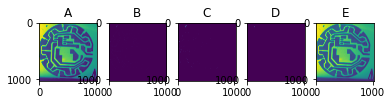

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
from urllib.request import urlopen

well = np.array(PIL.Image.open('C:/Users/Rakshith/Downloads/Good/Good/VCXG-201C.R/image0000087.png'))
well = cv2.cvtColor(well, cv2.COLOR_BGRA2GRAY)
plt.subplot(151); plt.title('A')
plt.imshow(well)

harris = cv2.cornerHarris(well,4, 1,0.00)
plt.subplot(152); plt.title('B')
plt.imshow(harris)

x, thr = cv2.threshold(harris, 0.1 * harris.max(), 255, cv2.THRESH_BINARY)
thr = thr.astype('uint8')
plt.subplot(153); plt.title('C')
plt.imshow(thr)

contours, hierarchy = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
areas = [cv2.contourArea(cv2.convexHull(x)) for x in contours]
max_i = areas.index(max(areas))
d = cv2.drawContours(np.zeros_like(thr), contours, max_i, 255, 1)
plt.subplot(154); plt.title('D')
plt.imshow(d)

rect = cv2.minAreaRect(contours[max_i])
box = cv2.boxPoints(rect)
box = np.int0(box)
e = cv2.drawContours(well,[box],0,1,1)
plt.subplot(155); plt.title('E')
plt.imshow(e)

In [ ]:
import os
import argparse
import time
import numpy as np
import torch
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from datasets.mvtec import MVTecDataset ,MVTecDataset_Test
from models.resnet_backbone import modified_resnet18
from utils.util import  time_string, convert_secs2time, AverageMeter
from utils.functions import cal_anomaly_maps, cal_loss
from utils.visualization import plt_fig
import glob
import cv2

def load_model(model_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    try:
        checkpoint = torch.load(os.path.join(model_dir, 'model_s_satyam.pth'))
    except:
        raise Exception('Check saved model path.')
    model_t = modified_resnet18().to(device)    
    model_s = modified_resnet18(pretrained=False).to(device)  
    for param in model_t.parameters():
        param.requires_grad = False
    model_t.eval()  
    model_s.load_state_dict(checkpoint['model'])
    model_s.eval()
    return model_t , model_s , device

def test(data_path,obj,vis,model_dir,img_dir):
    img_resize = 256
    img_cropsize = 224
    model_t , model_s , device = load_model(model_dir)
    kwargs = {'num_workers': 0, 'pin_memory': True} if torch.cuda.is_available() else {}
    # test_dataset = MVTecDataset(data_path, class_name=obj, is_train=False, resize=img_resize, cropsize=img_cropsize)
    test_dataset = MVTecDataset_Test(data_path, resize=img_resize, cropsize=img_cropsize)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, **kwargs)
    scores = []
    test_imgs = []
    gt_list = []
    gt_mask_list = []
    print('Testing')
    for (data, label, mask) in tqdm(test_loader):
        data[0] = 8
        test_imgs.extend(data.cpu().numpy())
        gt_list.extend(label.cpu().numpy())
        gt_mask_list.extend(mask.squeeze().cpu().numpy())

        data = data.to(device)
        with torch.set_grad_enabled(False):
            features_t = model_t(data)
            features_s = model_s(data)

            score = cal_anomaly_maps(features_s, features_t, img_cropsize)
        scores.extend(score)

    scores = np.asarray(scores)
    max_anomaly_score = scores.max()
    min_anomaly_score = scores.min()
    scores = (scores - min_anomaly_score) / (max_anomaly_score - min_anomaly_score)

    img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)
    gt_list = np.asarray(gt_list)
    print(gt_list)
    print(img_scores)

    precision, recall, thresholds = precision_recall_curve(gt_list.flatten(), img_scores.flatten())
    a = 2 * precision * recall
    b = precision + recall
    f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
    cls_threshold = thresholds[np.argmax(f1)]

    gt_mask = np.asarray(gt_mask_list)
    print(np.unique(gt_mask),'ggggggggggggggggggggggggggggggggggg')
    precision, recall, thresholds = precision_recall_curve(gt_mask.flatten(), scores.flatten())
    a = 2 * precision * recall
    b = precision + recall
    f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
    seg_threshold = thresholds[np.argmax(f1)]

    if vis == True:
        results_image , fig_img  = plt_fig(data_path ,test_imgs, scores, img_scores, gt_mask_list, seg_threshold, cls_threshold, 
                    img_dir, obj)
        return results_image   , fig_img         

if __name__ == '__main__':
    data_path = './mvtec/'
    obj = 'classic_stripes'
    vis = True
    save_path = './results'
    model_dir = save_path + '/models' + '/' + obj
    img_dir =  save_path + '/imgs' + '/' + obj
    count  = 0
    path = glob.glob(r'D:\Anomaly-Detection-Localization-master (2)\Anomaly-Detection-Localization-master\mvtec\classic_stripes\train\good\*png')
    for img in path :
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results_image,fig_img = test(image,obj,vis,model_dir,img_dir)
        fig_img.savefig(os.path.join("D:/Anomaly-Detection-Localization-master (2)/Anomaly-Detection-Localization-master/results/imgs/classic_stripes/heat_map_"+str(count)+".png"), dpi=300, bbox_inches='tight')
        cv2.imwrite("D:/Anomaly-Detection-Localization-master (2)/Anomaly-Detection-Localization-master//results/imgs/heatmap/heat_map_"+str(count)+".png",results_image)
        count = count + 1


In [10]:
from common.utils import *
from django.utils import timezone
from bson import ObjectId
from copy import deepcopy
import sqlite3
from xlsxwriter import Workbook
import datetime
import pymongo
from bson import ObjectId
import datetime
from datetime import date
import calendar
from csv import DictWriter
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from datetime import date


def get_name_byid(id):

    #print(id)

    command = "SELECT * FROM accounts_user WHERE user_id=" + '\"' + id + '\"'
    #print(command)

    conn = sqlite3.connect('D:/SE_PROJECT/livis-be-se-agilis_be/livis-be-se-agilis_be/AGILIS_BACKEND/db.sqlite3')
    cursor = conn.cursor()
#     cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    cursor.execute(command)
    lis = cursor.fetchone()
    
    #print(lis)
    #admin_name = "N.A"  
    
    
    if lis is not None and len(lis)>0:
    
        return str(lis[4])
    else:
        return "N.A"

def detail_report_util(data):
    try:
        from_date = data['from_date']
    except:
        from_date = None
    try:
        to_date = data['to_date']
    except:
        to_date = None
    try:
        jig_type = data['feature_type']
    except:
        jig_type = None
    try:
        operator_name = data['operator_name']
    except:
        operator_name = None    
    try:
        status_end = data['status_type']
    except:
        status_end = None  
        
    try:
        on_number = data['on_number']
    except:
        on_number = None  
    try:
        serial_number = data['serial_number']
    except:
        serial_number = None  		
            


    query_1 = []
    query_2 = []
    resp = {}
    resp_list = []

    today = date.today()
    day = today.strftime("%d")
    month = today.strftime("%m")
    year = today.strftime("20%y")
    start = str(year) + "-" + str(month) + "-" + str(day) +" "+ '00:00:00'
    end = today + relativedelta(months=-3)
    day = end.strftime("%d")
    month = end.strftime("%m")
    year = end.strftime("20%y")
    end = str(year) + "-" + str(month) + "-" + str(day) +" "+ '00:00:00'

    # start = datetime.date(2021, 12, 23)
    print(start)
    # end = datetime.date(2021, 12, 23)
    print(end)
    print(from_date)
    
    if (from_date is not None) :
        query_1.append({'createdAt': {"$gte":from_date}})#,"$lte":to_date
    if (from_date is None) :
        query_1.append({'createdAt': {"$gte":str(end)}})#,"$lte":to_date
    if (to_date is not None) :
        query_1.append({'completedAt': {"$lte":to_date}})
    if (to_date is None) :
        query_1.append({'completedAt': {"$lte":str(start)}})
    if jig_type is not None :
        query_1.append({'jig_details.jig_type': jig_type})
    if on_number is not None :
        query_1.append({'jig_details.oem_number': on_number})
    if operator_name is not None :
        query_1.append({'user.user_id': operator_name})
    if status_end is not None:
        query_1.append({'status_end':status_end})
    if serial_number is not None:
        query_1.append({'serial_no':serial_number})		
    print(operator_name)
    print(serial_number,'ssssssssssssssssssssssssssssssssssss')
    print(query_1)
    

    
    myclient = pymongo.MongoClient("mongodb://localhost:27017/")
    mydb = myclient["LIVIS"]
    
    all_lst = mydb.collection_names()
    
    insp_lst = []
    
    for a_lst in all_lst:
        if 'INSPECTION' in a_lst:
             insp_lst.append(a_lst)
    
    for i_lst in insp_lst:
    
        #COLL_NAME = "INSPECTION_"+datetime.datetime.now().strftime("%m_%y")
        process_collection = MongoHelper().getCollection(i_lst)
        
        
        if bool(query_1):
            pr_ids = [i['_id'] for i in process_collection.find({"$and":query_1}).sort([( '$natural', -1)])]
        else:
            pr_ids = [i['_id'] for i in process_collection.find().sort([( '$natural', -1)])]
        

        for ind , pr_id in enumerate(pr_ids):
            res = process_collection.find({"_id":pr_id})
            #print(pr_id)
            #print(res)
            for r in res:
                if 'approved_by' in list(r.keys()):
                
                    name = get_name_byid(r["approved_by"])
                
                    resp_list.append({"id":ind,
                                "on_number": r["jig_details"]["oem_number"],
                                'operator_name': r['user']['name'] ,
                                'jig_type':r["jig_details"]["jig_type"],
                                "serial_number":r["serial_no"],
                                'scanned_at':r["createdAt"],
                                # "completed_at":r["completedAt"],
                                "status":r["status_end"],
                                "num_retry":r["num_retry"],
                                "approved_by":name})
                else:
                    resp_list.append({"id":ind,
                        "on_number": r["jig_details"]["oem_number"],
                        'operator_name': r['user']['name'] ,
                        'jig_type':r["jig_details"]["jig_type"],
                        "serial_number":r["serial_no"],
                        'scanned_at':r["createdAt"],
                        # "completed_at":r["completedAt"],
                        "num_retry":r["num_retry"],
                        "status":r["status_end"],
                        "approved_by":None})
                   
                   
                   
    return resp_list


d:\Anaconda\envs\mmtest\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Anaconda\envs\mmtest\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\Anaconda\envs\mmtest\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


D:\SE_PROJECT\livis-be-se-agilis_be\livis-be-se-agilis_be\AGILIS_BACKEND
AREEEEE: : : : :    D:\SE_PROJECT\livis-be-se-agilis_be\livis-be-se-agilis_be\AGILIS_BACKEND/training/image_data/


In [11]:
# data = {'from_date': "2023-02-06 00:00:00", 'to_date': "2023-02-06 23:59:59"}
data =  detail_report_util(data)
print(data)


2023-02-08 00:00:00
2022-11-08 00:00:00
None
None
None ssssssssssssssssssssssssssssssssssss
[{'createdAt': {'$gte': '2022-11-08 00:00:00'}}, {'completedAt': {'$lte': '2023-02-08 00:00:00'}}]


C:\Users\Rakshith\AppData\Local\Temp\ipykernel_14736\1683200276.py:124: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  all_lst = mydb.collection_names()


[{'id': 0, 'on_number': 'ON-2213', 'operator_name': 'operator_1 123', 'jig_type': 'AGILIS', 'serial_number': '', 'scanned_at': '2023-02-07 18:39:39', 'num_retry': 2, 'status': 'Auto Pass', 'approved_by': None}, {'id': 1, 'on_number': 'ON-2213', 'operator_name': 'operator_1 123', 'jig_type': 'AGILIS', 'serial_number': '', 'scanned_at': '2023-02-07 18:37:51', 'num_retry': 3, 'status': 'Auto Pass', 'approved_by': None}, {'id': 2, 'on_number': 'ON-2213', 'operator_name': 'operator_1 123', 'jig_type': 'AGILIS', 'serial_number': '', 'scanned_at': '2023-02-07 18:34:43', 'num_retry': 3, 'status': 'Auto Pass', 'approved_by': None}, {'id': 3, 'on_number': 'ON-2213', 'operator_name': 'operator_1 123', 'jig_type': 'AGILIS', 'serial_number': '', 'scanned_at': '2023-02-07 18:03:42', 'status': 'Manually Pass', 'num_retry': 0, 'approved_by': 'anusha'}, {'id': 4, 'on_number': 'ON-2213', 'operator_name': 'operator_1 123', 'jig_type': 'AGILIS', 'serial_number': '', 'scanned_at': '2023-02-07 18:00:46', 's

In [9]:
today = date.today()
day = today.strftime("%d")
month = today.strftime("%m")
year = today.strftime("20%y")
start = str(year) + "-" + str(month) + "-" + str(day)
end = today + relativedelta(months=-3)
day = end.strftime("%d")
month = end.strftime("%m")
year = end.strftime("20%y")
end = str(year) + "-" + str(month) + "-" + str(day)

'2023-02-06'

In [1]:
import torch
import pandas as pd
import cv2
def model_torch(img_path):
	img = cv2.imread(img_path)
	final_img = img.copy()
	model = torch.hub.load("D:/Segmentatin_yolo/LINCODE_AI_WORKER/segment/LINCODE_AI/",'custom',path="D:/24JAN/best.pt",source = 'local',force_reload=True,autoshape=True)
	model.conf = 0.25
	model.iou = 0.1
	results = model(img,size=1280)
	results.xyxy[0] 
	df = pd.DataFrame(results.pandas().xyxy[0]).sort_values('xmin')
	df_gen = df.loc[df.name == 'IGBT']
	return df_gen,final_img

d:\Anaconda\envs\mmdatanew\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
img_path = r"D:\24JAN\VCXG-201C.R\DATA\image0000035.png"
df_gen,final_img = model_torch(img_path)

YOLOv5  v7.0-46-g96a71b1 Python-3.8.8 torch-1.9.0+cu111 CUDA:0 (NVIDIA GeForce GTX 1050, 4096MiB)

Fusing layers... 
Model summary: 276 layers, 35248920 parameters, 0 gradients
Adding AutoShape... 


In [11]:
cv2.imwrite('image.png',final_img)

True

In [7]:
df_gen

,xmin,ymin,xmax,ymax,confidence,class,name
0,1420.916382,1386.243896,2193.247803,2334.989014,0.906057,0,IGBT
3,2530.389404,1502.486694,3143.109863,2309.577393,0.627011,0,IGBT
1,3450.974854,1377.938110,4156.025391,2374.586426,0.824506,0,IGBT
2,4370.779297,1323.848389,5116.327637,2283.196533,0.802855,0,IGBT


In [9]:
actual_count  = len(df_gen.index)
count = actual_count + 1
print(count)

5


In [28]:
from common.utils import *
from django.utils import timezone
from bson import ObjectId
from copy import deepcopy
import sqlite3
from xlsxwriter import Workbook
import datetime
import pymongo
from bson import ObjectId
import datetime
from datetime import date
import calendar
from csv import DictWriter
from datetime import datetime, timedelta
from dateutil.relativedelta import *
import datetime

def get_kanban(oem_number):
            mp = MongoHelper().getCollection("jig")
            for x in mp.find():
                if x['oem_number'] == oem_number:
                    kanban = x.get('kanban')	
                    return kanban

def heak_sink(oem_number):
    mp = MongoHelper().getCollection("jig")
    for x in mp.find():
        if x['oem_number'] == oem_number:
            heak_sink = x.get('heatsink_match')	
            return heak_sink                    


COLL_NAME = "INSPECTION_"+datetime.datetime.now().strftime("%m_%y")
mp = MongoHelper().getCollection(COLL_NAME)

In [29]:
oem_number = 'ON-2213'
value = heak_sink(oem_number)
value

'HH-2213'

In [37]:

p = [p for p in mp.find().sort( "$natural", -1 )]
value = []
for i in p:
    if i['is_admin_report_reset'] == True :
          value.append(i['_id'])

value[0]
dataset1 = [p for p in mp.find({"status_end":"Auto Pass"})]
dataset2 = [p for p in mp.find({"is_reject":"Manually Rejected"})]
dataset3 = [p for p in mp.find({"status_end":"Manually Pass"})]
total_accepted_count = len(dataset1) + len(dataset3)
total_rejected_count = len(dataset2)


ObjectId('63e2280e7af90e22958d9681')

In [ ]:
if i['is_admin_report_reset'] is True:
                    break

In [28]:
retry_list = ["1","2","3"]
if len(retry_list) == 4:
    print("Manul_Reject")

In [2]:
oem_number = 'ON-2213'
value = get_kanban(oem_number)


 actual['part_number']

In [12]:
def convert_value_to_kanban(value):
    import re
    for p in value:
        for i in p['part_number']:
            value_test = []
            if '_' in i:
                end = (len(i))
                start = (i.index('_'))
                remove = (i[start:end])
                new_value = i.replace(remove, '')
                value_test.append(new_value)
            if not value_test:
                pass
            else:
                p.update({'part_number' : value_test})
            # i['part_number'].update(new_value)
    return value
            

In [16]:
value = [{'part_number': ['30APF10_big'], 'part_type': 'IGBT', 'position': 1},
 {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 2},
 {'part_number': ['40N120FL2_big'], 'part_type': 'IGBT', 'position': 3},
 {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 4},
 {'part_number': ['R6076ENZ4_matte','R6076ENZ4_big'], 'part_type': 'IGBT', 'position': 5},
 {'part_number': ['30APF10'], 'part_type': 'IGBT', 'position': 6},
 {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 7},
 {'part_number': ['40N120FL2'], 'part_type': 'IGBT', 'position': 8},
 {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 9},
 {'part_number': ['R6076ENZ4'], 'part_type': 'IGBT', 'position': 10}]
value = convert_value_to_kanban(value)
print(value)

[{'part_number': ['30APF10'], 'part_type': 'IGBT', 'position': 1}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 2}, {'part_number': ['40N120FL2'], 'part_type': 'IGBT', 'position': 3}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 4}, {'part_number': ['R6076ENZ4'], 'part_type': 'IGBT', 'position': 5}, {'part_number': ['30APF10'], 'part_type': 'IGBT', 'position': 6}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 7}, {'part_number': ['40N120FL2'], 'part_type': 'IGBT', 'position': 8}, {'part_number': ['K100T60'], 'part_type': 'IGBT', 'position': 9}, {'part_number': ['R6076ENZ4'], 'part_type': 'IGBT', 'position': 10}]


In [ ]:
import re
for p in value:
    for i in p['part_number']:
        value_test = []
        if '_' in i:
            end = (len(i))
            start = (i.index('_'))
            remove = (i[start:end])
            new_value = i.replace(remove, '')
            value_test.append(new_value)
        if not value_test:
            pass
        else:
            p.update({'part_number' : value_test})
            # i['part_number'].update(new_value)

            